## DICE - Notebook 4.1 - Model Loading and Testing - Cleaned Data

<br/>

```
*************************************************************************
**
** 2017 Mai 23
**
** In place of a legal notice, here is a blessing:
**
**    May you do good and not evil.
**    May you find forgiveness for yourself and forgive others.
**    May you share freely, never taking more than you give.
**
*************************************************************************
```

<table style="width:100%; font-size:14px; margin: 20px 0;">
    <tr>
        <td style="text-align:center">
            <b>Contact: </b><a href="mailto:contact@jonathandekhtiar.eu" target="_blank">contact@jonathandekhtiar.eu</a>
        </td>
        <td style="text-align:center">
            <b>Twitter: </b><a href="https://twitter.com/born2data" target="_blank">@born2data</a>
        </td>
        <td style="text-align:center">
            <b>Tech. Blog: </b><a href="http://www.born2data.com/" target="_blank">born2data.com</a>
        </td>
    </tr>
    <tr>
        <td style="text-align:center">
            <b>Personal Website: </b><a href="http://www.jonathandekhtiar.eu" target="_blank">jonathandekhtiar.eu</a>
        </td>
        <td style="text-align:center">
            <b>RSS Feed: </b><a href="https://www.feedcrunch.io/@dataradar/" target="_blank">FeedCrunch.io</a>
        </td>
        <td style="text-align:center">
            <b>LinkedIn: </b><a href="https://fr.linkedin.com/in/jonathandekhtiar" target="_blank">JonathanDEKHTIAR</a>
        </td>
    </tr>
</table>

## Objectives

This notebook aims to preprocess and prepare the dataset for later used during the training phase. 

There exists many methods to feed data into a Deep Learning with [Tensorflow](https://www.tensorflow.org/), the Python Library we have chosen to use for this study:

1. **From Disk**: Data can be inputed into a model with the **feed_dict** argument when running a *training operation*. It would  definitely be possible, however this process can be slow if there are a lot of data to read simultaneously and could be too large to be held in the GPU Memory.
<br><br>
2. **From a CSV File**: This [type of file](https://en.wikipedia.org/wiki/Comma-separated_values) is not revelant when dealing with images.
<br><br>
3. **From a preprocessed binary file**: Tensorflow is able to save and recover data in a binary format called [TFRecords](https://www.tensorflow.org/api_guides/python/python_io#TFRecords_Format_Details). The data can be preprocessed beforehand and only the necessary data can be saved and read in real time during the training. This approach is the fatest and most memory-efficient when dealing with images.

This notebook will focus on generating the necessary **TFRecord** files. Generating **TFRecords** is less intuitive than 
[HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), used in other Deep Learning libraries such as [Keras](https://keras.io/). Using **TFRecords** will give you access to natively available tools, such as *Queue Runners*, *Coordinators*, *Supervisors*, *etc.*, to design [data pipelines](https://www.tensorflow.org/programmers_guide/reading_data) and process the images in a batch fashion.

This notebook will use [Tensorflow-Slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) to ease the understanding and reduce the code complexity.

As we aim to to later re-train a CNN Model

This will be used later to retrain an CNN model: [Inception-V4](https://arxiv.org/abs/1602.07261) model developed by Szegedy et al. The model has been Pre-Trained with the [ImageNet](http://www.image-net.org/) dataset allowing a much more accurate result due to the large number of data avaiable in this dataset. We call this kind of process: "*Transfer Learning*".


This notebook will also randomly split the available data into two sets of data: [Training and Validation sets](https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set). This process aims to reduce the [overfit](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html) of the model and thus improving its accuracy on previously unseen data. 

In this study the selection ratio has been chosen as followed:
- *training set:* 60%
- *validation set:* 40%.

---

As reminder before starting, the data have already been preprocessed (resized, augmented, etc.) in the first Notebook: **[DICE - Notebook 1 - Dataset Augmentation](https://github.com/DEKHTIARJonathan/DICE-DMU_Imagery_Classification_Engine/blob/master/DICE%20-%20Notebook%201%20-%20Dataset%20Augmentation.ipynb)**

The preprocessed data all have been saved as **JPEG images** and thus we will only focus on these data.

## 1. Notebook Initialisation

### 1.1. Load the necessary libraries

In [1]:
import os, sys, io
import urllib.request, urllib.error, urllib.parse

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

%matplotlib inline

sys.path.append("inception_files")

from datasets import imagenet
from nets.inception_v1 import inception_v1, inception_v1_arg_scope, inception_v1_base
from preprocessing import inception_preprocessing

slim = tf.contrib.slim

image_size   = inception_v1.default_image_size

model_path       = 'output/computed_models/'
model_name       = 'dmunet_cleaned_data.ckpt'

label_file_path  = model_path + "dmunet_labels.txt"

if not os.path.isfile(label_file_path):
    names = imagenet.create_readable_names_for_imagenet_labels()
else:
    labels = open(label_file_path, 'r')

    #Create a dictionary to refer each label to their string name
    names = {}
    for line in labels:
        label, string_name = line.split(':')
        string_name = string_name[:-1] #Remove newline
        names[int(label)] = string_name
        

image_url        = 'http://www.cycle-en-terre.be/sites/cycle-en-terre.be/files/styles/product_image_big/public/tournesol1.jpg'
image_data       = urllib.request.urlopen(image_url)
image_string     = image_data.read()

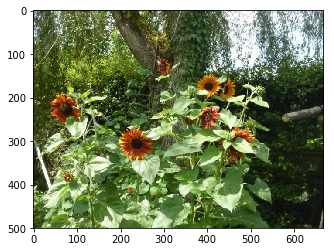

In [2]:
img = Image.open(io.BytesIO(image_string))
plt.imshow(np.asarray(img))

In [3]:
image_ext = image_url.split(".")[-1:][0].lower()

jpeg_ext_list = ["jpg", "jpeg"]

file_cond = tf.equal(image_ext, jpeg_ext_list)
file_cond = tf.count_nonzero(file_cond)
file_cond = tf.equal(file_cond, 1) ## 1 => JPEG EXTENSION, 0 => PNG EXTENSION
        
image = tf.cond(
    file_cond, 
    lambda: tf.image.decode_jpeg(image_string, channels=3), 
    lambda: tf.image.decode_png(image_string, channels=3)
)

In [4]:
processed_image   = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
processed_images  = tf.expand_dims(processed_image, 0)

In [ ]:
# Create the model, use the default arg scope to configure the batch norm parameters.
with slim.arg_scope(inception_v1_arg_scope()):
    logits, _ = inception_v1(processed_images, num_classes=5, is_training=False)
    
probabilities   = tf.nn.softmax(logits)

init_fn = slim.assign_from_checkpoint_fn(
    model_path + model_name,
    slim.get_variables_to_restore()
)

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    
    init_fn(sess)
    np_image, probabilities = sess.run([image, probabilities])
    probabilities = probabilities[0, 0:]
    sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]

    for i in range(5):
        index = sorted_inds[i]
        print(('Probability %2.2f%% => [%s]' % (100*probabilities[index], names[index])))

    plt.figure(num=1,figsize=(8, 6), dpi=80)
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

INFO:tensorflow:Restoring parameters from output/computed_models/dmunet_cleaned_data.ckpt
